# Miniminiai Tutorial 1: Introduction

This is a minimal example to get you started, showing the basic flow of training a model using (mini)miniai.



# Setup

Installing the library and importing a few useful things

In [ ]:
# Imports
import torch.nn as nn
import minai as mi # So we can see what is from minai in this tutorial
import torchvision.transforms.functional as TF
from datasets import load_dataset
from torcheval.metrics import  MulticlassAccuracy

# Preparing the DataLoaders

The dataloaders is just a tiny wrapper around two pytorch dataloaders, dls.train and dls.valid. You can create your dataloaders with `dls=DataLoaders(train_dl, valid_dl)` or use the `from_dd` method like we do here to load them from a DatasetDict (for datasets from huggingface with the datasets library):



In [ ]:
# Load a dataset from HF
dataset = load_dataset('mnist')

# Specify transforms
def transforms(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b
dataset = dataset.with_transform(transforms)

# Turn it into dls
dls = mi.DataLoaders.from_dd(dataset,batch_size=64)

# Look at the data
xb, yb = next(iter(dls.train))
xb.shape, yb.shape, yb[:5]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([64, 1, 28, 28]), torch.Size([64]), tensor([8, 4, 0, 3, 6]))

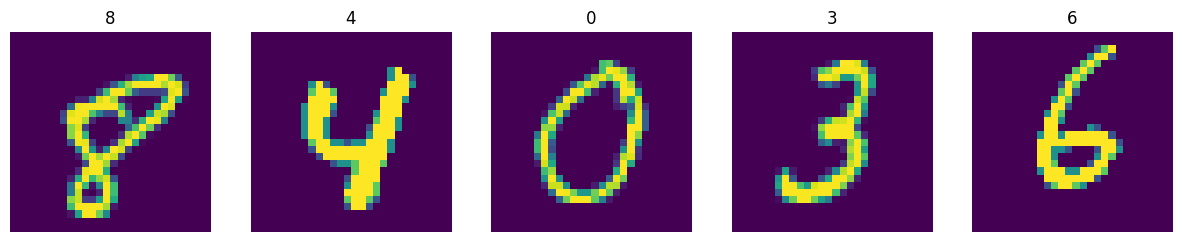

In [ ]:
# The library has some useful utility functions such as:
mi.show_images(xb[:5], ncols=5, titles=list(yb[:5].numpy()))

You can do a lot of fancy stuff with your collate function if your data requires more processing or augmentation.

# Prepare the Model

The model can be pretty much any PyTorch model, no changes needed here :)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)

# Create and Fit the Learner

The heart of (mini)miniai is the Learner class. It pulls together the data, model and loss function, and can be extended in all sorts of cool ways using callbacks. Here's a somewhat minimal example, training our model on this classification task and plotting some stats as we do so:

In [ ]:
# There are callbacks for all sorts of things, here are some common ones:
cbs = [
    mi.TrainCB(), # Handles the core steps in the training loop. Can be left out if using TrainLearner
    mi.DeviceCB(), # Handles making sure data and model are on the right device
    mi.MetricsCB(accuracy=MulticlassAccuracy()), # Keep track of any relevant metrics
    mi.ProgressCB(), # Displays metrics and loss during training, optionally plot=True for a pretty graph
]

# Nothing fancy for the loss function
loss_fn = nn.CrossEntropyLoss()

# The learner takes a model, dataloaders and loss function, plus some optional extras like a list of callbacks
learn = mi.Learner(model, dls, loss_fn, lr=0.1, cbs=cbs)

# And fit does the magic :)
learn.fit(3)

accuracy,loss,epoch,train
0.337,1.853,0,train
0.587,1.261,0,eval
0.707,0.906,1,train
0.801,0.648,1,eval
0.819,0.586,2,train
0.838,0.522,2,eval


When I get around to making more complex tutorials I'll try to show some of the other existing callbacks in action, but for most tasks this is pretty much all you need! The model (`learn.model`) is just a regular PyTorch model, so you can save it and load it later somewhere else without needing any minai code at all. 